In [2]:
import os
from collections import Counter
import hashlib
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import logging
import ffmpeg
from io import BytesIO
from typing import Union, List, Tuple
from pathlib import Path

from datetime import datetime
from tqdm.notebook import tqdm

from rts.db.dao import DataAccessObject
from rts.db_settings import DATABASE_URL
from rts.db.queries import get_library_id_from_name
from rts.api.models import Media
from rts.db.queries import create_media
from rts.storage.storage import get_storage_client
from rts.api.models import Media

from IPython.display import Video

logging.basicConfig(level=logging.INFO)

load_dotenv()
DataAccessObject().connect(DATABASE_URL)

In [3]:
# Setup before we can create media objects
OUTDIR = 'data'
archive_name =  "ioc"
bucket_name =  archive_name
library_id =  get_library_id_from_name(archive_name)
library_id

3

In [4]:
metadata = '../data/metadata.hdf5'
with pd.HDFStore(metadata) as store:
    keys = store.keys()
    df = store.get(keys[0])  

In [5]:
def find_mp4_files(root_folder):
    mp4_files = []

    for foldername, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.mp4'):
                mp4_files.append(os.path.join(foldername, filename))

    return mp4_files

In [6]:
mp4_files = find_mp4_files("/media/data/ioc/videos/")
print(f"Found {len(mp4_files)} mp4 files")
print(f"Found {df.guid.nunique()} unique guids")

Found 31304 mp4 files
Found 21712 unique guids


In [7]:
file_map = {}
for mp4 in mp4_files:
    file_map[mp4.split('/')[-1].split('.')[0]] = mp4

guids = set(df['guid'].tolist())
len(guids)

21712

In [8]:
# check if guids are in the file map
counter = 0
for key in file_map.keys():
    if key not in guids:
        counter += 1
print(f"Missing {counter} files")

# check the other way around
counter = 0
for guid in guids:
    if guid not in file_map.keys():
        counter += 1
print(f"Missing {counter} guids")

Missing 13527 files
Missing 18486 guids


In [9]:
# How many files do we have where the metadata matches the file id?
len(set(df.guid.tolist()) & set(file_map.keys()))
print(f"Found {len(set(df.guid.tolist()) & set(file_map.keys()))} matches")

Found 3226 matches


In [10]:
# keep only the sequences that we have the video for
df_seq = df[df.guid.isin(list(set(df.guid.tolist()) & set(file_map.keys())))]

In [11]:
# Check which olympic games the sequences are from
df_seq.date.apply(lambda x: x.year).value_counts()

date
2021    674342
1996        37
2012         3
1998         1
Name: count, dtype: int64

In [12]:
guid_counter = Counter()

for guid in df.guid.unique().tolist():
    guid_counter[guid[:4]] += 1

print(f"Most common guids in DataFrame: {guid_counter.most_common(10)}")

file_counter = Counter()

for guid in file_map.keys():
    file_counter[guid[:4]] += 1

print(f"Most common guids for the MP4 Files: {file_counter.most_common(10)}")

Most common guids in DataFrame: [('MDA3', 11791), ('MDA4', 9921)]
Most common guids for the MP4 Files: [('MDA4', 16724), ('MDA3', 18), ('MDA2', 11)]


In [13]:
def trim(input_path: Union[str, Path], start_ts: int, end_ts: int) -> BytesIO:
    try:
        out, _ = (
            ffmpeg
            .input(str(input_path), ss=start_ts)
            .output(
                "pipe:1", 
                format='mp4', 
                vcodec='libx264', 
                acodec='aac', 
                ab='128k',
                t=end_ts - start_ts,
                strict='experimental', 
                movflags='faststart+frag_keyframe+empty_moov'
            )
            .run(capture_stdout=True, capture_stderr=True)
        )
        return BytesIO(out)
    except ffmpeg.Error as e:
        print(f'FFmpeg Error: {e.stderr.decode()}')
    
    return None

In [14]:
# Normalize the timestamps for the clips
df_seq.loc[:, 'start_ts'] = df_seq.start.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())
df_seq.loc[:, 'end_ts'] = df_seq.end.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())
df_seq.loc[:, 'end_ts'] = df_seq.end_ts - df_seq.start_ts.min()
df_seq.loc[:, 'start_ts'] = df_seq.start_ts - df_seq.start_ts.min()

/tmp/ipykernel_213864/2354081778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq.loc[:, 'start_ts'] = df_seq.start.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())
/tmp/ipykernel_213864/2354081778.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq.loc[:, 'end_ts'] = df_seq.end.apply(lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds())


In [15]:
df_norm = df_seq[df_seq.guid == 'MDA42810489']
df_norm.shape

(479, 17)

In [16]:
def get_frame_rate(input_path: Union[str, Path]) -> float:
    probe = ffmpeg.probe(str(input_path))
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream is None:
        return None
    
    r_frame_rate = video_stream['r_frame_rate']
    num, den = map(int, r_frame_rate.split('/'))
    return num / den

In [17]:
frame_rates = {}
clips = {}
media_ids = {}

for i, row in df_norm.iterrows():

    media_id = row.guid + "IOC" + str(i).zfill(5)
    original_path = file_map[row.guid]
    media_path = f"videos/{row.guid}/{row.seq_id}.mp4"
    
    if frame_rates.get(original_path) is None:
        frame_rates[original_path] = get_frame_rate(original_path)

    metadata = {
        # 'sport': row.sport,
        # 'description': row.description,
        # 'event': row.event,
        # 'category': row.category,
        # 'round': row['round'],
        # 'raw_round': row.raw_round,
    }

    media_ids[media_id] = row
    
    clips[media_id] = Media(**{
        'media_id': row.seq_id,
        'original_path': original_path,
        'original_id': row.guid,
        'media_path': media_path, 
        'media_type': "video",
        'sub_type': "clip", 
        'size': -1, # write size later when we process the clips 
        'metadata': metadata,
        'library_id': library_id, 
        'hash': hashlib.md5(media_path.encode()).hexdigest(), 
        'parent_id': -1,
        'start_ts': row.start_ts, 'end_ts': row.end_ts, 
        'start_frame': row.start_ts * frame_rates[original_path], 'end_frame': row.end_ts * frame_rates[original_path], 'frame_rate': frame_rates[original_path], 
    })

In [87]:
for key in tqdm(clips):
    try:
        # print(clips[key].original_path, media_ids[key].start_ts, media_ids[key].end_ts)
        buffer = trim(clips[key].original_path, media_ids[key].start_ts, media_ids[key].end_ts)
        clips[key].size = len(buffer.getvalue())
        get_storage_client().upload_binary(bucket_name, clips[key].media_path, buffer)
        create_media(clips[key])
    except IntegrityError as e:
        if "duplicate key value violates unique constraint" in str(e):
            pass
            # logging.info(f'UniqueViolation: Duplicate media_id {clips[key].media_id}')
        else:
            raise e

  0%|          | 0/479 [00:00<?, ?it/s]

/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 0.0 33.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 33.0 46.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 46.0 58.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 58.0 187.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 187.0 238.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 238.0 271.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 271.0 294.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 294.0 306.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 306.0 317.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 317.0 328.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 328.0 341.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 341.0 360.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 360.0 373.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 373.0 382.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 382.0 394.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 394.0 410.0
/media/data/ioc/videos/9/8/MDA42810489.LR.mp4 410.0 419.0
/media/data/ioc/videos

KeyboardInterrupt: 

<Axes: >

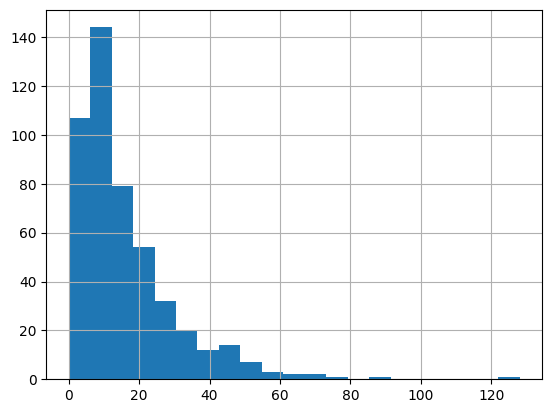

In [19]:
df_norm.duration_sec.hist(bins=21)

In [20]:
total_duration = 0
for i, row in df_norm.iterrows():
    print(i, row.seq_id, row.duration_sec, row.description, row.duration, total_duration, datetime.strptime(row.start, '%H:%M:%S') - datetime.strptime(df_norm.iloc[0].start, '%H:%M:%S'), row.start)
    total_duration += row.end_ts - row.start_ts

2262563 SEQ42811242 33.0 Sport Climbing ; Women's Combined, Bouldering Qual. ; Venue ID graphic 0 days 00:00:33 0 0:00:00 17:56:03
2262564 SEQ42811245 12.0 Sport Climbing ; Women's Combined, Bouldering Qual. ; Weather graphic 0 days 00:00:12 33.0 0:00:33 17:56:36
2262565 SEQ42811249 12.0 Sport Climbing ; Women's Combined ; Qualifications ; Qualification Bouldering ; Women's Combined, Bouldering Qual. ; Event ID graphic 0 days 00:00:12 46.0 0:00:46 17:56:49
2262566 SEQ42811253 128.0 Sport Climbing ; Women's Combined ; Qualifications ; Qualification Bouldering ; Women's Combined, Bouldering Qual. ; Course animation 0 days 00:02:08 58.0 0:00:58 17:57:01
2262567 SEQ42811257 51.0 Sport Climbing ; Women's Combined ; Qualifications ; Qualification Bouldering ; Women's Combined, Bouldering Qual. ; Start list graphic 0 days 00:00:51 187.0 0:03:07 17:59:10
2262568 SEQ42811261 33.0 Sport Climbing ; Women's Combined ; Qualifications ; Qualification Bouldering ; Women's Combined, Bouldering Qual. ;

In [28]:
def get_sequence_from_storage(guid: str, seq_id: str, bucket_name='ioc') -> bytes:
    file_path = f"{OUTDIR}/{seq_id}.mp4"
    result = get_storage_client().download(bucket_name, f"videos/{guid}/{seq_id}.mp4")
    seq = df_norm[df_norm.seq_id == seq_id]
    print(seq.description.values[0])
    with open(f"{OUTDIR}/{seq_id}.mp4", "wb") as file:
        file.write(result)
    return Video(file_path)

In [34]:
seq_id = 'SEQ42811321'
get_sequence_from_storage('MDA42810489', 'SEQ42813093')

NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.